In [63]:
import requests

## Объявление констант

In [64]:
TOKEN = "f185ecc4f185ecc4f185ecc42cf296de11ff185f185ecc49599ca335d0fd6a7c8d49da4"
first_group = 'buh.mephi'
second_group = 'icismephi'
BASIC_RESPONSE = 'https://api.vk.com/method/'
V = 5.131

# Получение списков групп и их сравнение

### Запрос к API. Метод getMembers

In [65]:
def get_member(group_id, offset=0):
    response = requests.get(BASIC_RESPONSE + 'groups.getMembers', params={
            'access_token': TOKEN,
            'v': V,
            'offset': offset, 
            'sort':'id_desc',
            'group_id': group_id
        }).json()
    
    if 'response' in response:
        return response['response']

### Создание класса Группа

In [66]:
class Group:
    def __init__(self, group_name):
        self.group_name = group_name
        self.members = []
        self.posts = []
        
    def set_members(self):
        count = get_member(self.group_name)['count'] 

        if count == 0:
            return members_list 
        # Вычитаем остаток от деления на 1000, чтобы получить количество в тысячах 
        max_offset = count - count % 1000

        for offset in range(0, max_offset+1, 1000):
            offset_members = get_member(self.group_name, offset)
            
            if offset_members is not None:
                self.members.extend(offset_members['items']) 

### Инициализация объектов класса

In [67]:
iftes_group = Group(first_group)
icis_group = Group(second_group)

In [68]:
iftes_group.set_members()
icis_group.set_members()

# Построение социального графа

### Запрос к API. Метод friends.get

In [69]:
def get_friends(user_id):
    response = requests.get(BASIC_RESPONSE + 'friends.get', params={
        'access_token': TOKEN,
        'v': V,
        'user_id': user_id
    }).json()
    
    if 'error' in response:
        return set()
    else: 
        return set(response['response']['items'])

### Получаем данные для графа

In [70]:
def set_graph_data(first_users, second_users):
    graph = {}
    all_users = first_users | second_users 
    
    for user in all_users:
        friends = get_friends(user)
        common_friends = friends & all_users
        graph[user] = list(common_friends)
        
    return graph 

In [71]:
graph_data = set_graph_data(set(iftes_group.members),set(icis_group.members))

### Построение графа

In [72]:
import networkx as nx

In [73]:
all_users = set(iftes_group.members) | set(icis_group.members)

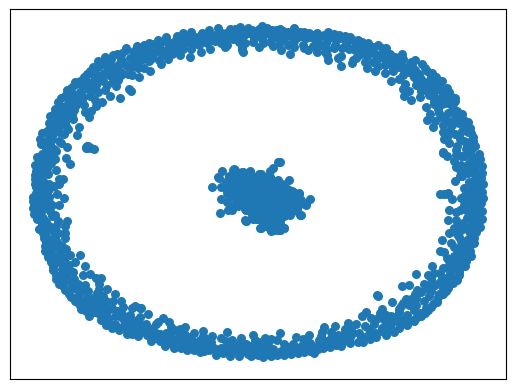

In [74]:
g = nx.Graph(directed=False)
for i in graph_data:
    g.add_node(i)
    for j in graph_data[i]:
        if i != j and i in all_users and j in all_users:
            g.add_edge(i, j)
            
nx.spring_layout(g)
nx.draw_networkx(g, with_labels=False, width=0.2, node_size=30)

In [75]:
nodes=g.number_of_nodes()
print ("Кол-во узлов = ", nodes)
edges=g.number_of_edges()
print ("Кол-во ребер = ", edges)

Кол-во узлов =  2842
Кол-во ребер =  9869


## Центральность графа

In [82]:
authority_users = sorted(list(nx.betweenness_centrality(g).items()), key=lambda i: i[1], reverse=True)
authority_users[:10]

[(195300974, 0.05483647610894952),
 (7337268, 0.052601238584999384),
 (166323702, 0.03867762893720629),
 (3691898, 0.03424186727921542),
 (304244101, 0.03060221819287435),
 (88933032, 0.029663100471502328),
 (57174220, 0.027637110584370697),
 (498716342, 0.023983009483941827),
 (2193869, 0.015344125426442416),
 (607849527, 0.01468855563415455)]

## Плотность графа

In [86]:
nx.density(g)

0.002444600168290744

## Связность графа

In [88]:
is_connected = nx.is_connected(g)
"Граф связный" if is_connected else "Граф несвязный"

'Граф несвязный'

## Степени узлов 

In [91]:
degrees = [val for (node, val) in g.degree()]

In [97]:
print(f"Максимальное значение степени узлов: {max(degrees)}")
print(f"Минимальное значение степени узлов: {min(degrees)}")
print(f"Среднее значение степени узлов:", "{:.3f}".format(sum(degrees)/len(degrees))) 

Максимальное значение степени узлов: 260
Минимальное значение степени узлов: 0
Среднее значение степени узлов: 6.945


## Модулярность графа

In [98]:
from networkx.algorithms import community

In [100]:
nx.community.modularity(g, nx.community.label_propagation_communities(g))

0.38659040585382154